# Forecasting Gross Broadway Sales using Facebook Prophet

Our goal in this notebook is to use Facebook Prophet to build a model that will predict the gross sales for a particular theater; in this case, Gershwin Theater.

## Setup

Let us first import the packages we need.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import notebook
import plotly
import ipywidgets
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [2]:
from prophet import Prophet

Next, we read in the data file `grosses.csv`.

In [3]:
df_raw = pd.read_csv('../DATA-COLLECTION/grosses.csv')
df_raw.head()

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


Next, we perform a bit of exploration to see if there's anything odd about the data.

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47524 entries, 0 to 47523
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   week_ending           47524 non-null  object 
 1   week_number           47524 non-null  int64  
 2   weekly_gross_overall  47524 non-null  float64
 3   show                  47524 non-null  object 
 4   theatre               47524 non-null  object 
 5   weekly_gross          47524 non-null  float64
 6   potential_gross       34911 non-null  float64
 7   avg_ticket_price      47524 non-null  float64
 8   top_ticket_price      36167 non-null  float64
 9   seats_sold            47524 non-null  int64  
 10  seats_in_theatre      47524 non-null  int64  
 11  pct_capacity          47524 non-null  float64
 12  performances          47524 non-null  int64  
 13  previews              47524 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 5.1+ MB


The columns we're interested in are `week_ending`, `theatre`, and `weekly_gross`. Happily, none of these columns have null values.

Let's also get some simple stats to get an idea of the numbers we're working with.

In [5]:
df_raw.describe()

,week_number,weekly_gross_overall,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
count,47524.000000,4.752400e+04,4.752400e+04,3.491100e+04,47524.000000,36167.000000,47524.000000,47524.000000,47524.000000,47524.000000,47524.000000
mean,27.372170,1.669303e+07,5.744868e+05,9.395982e+05,67.914736,189.681892,7893.449668,1237.793536,0.802753,7.237754,0.583663
std,15.310139,9.520198e+06,4.433470e+05,4.193233e+05,38.589416,112.304515,3186.019908,358.357398,0.176418,2.229733,1.926202
min,1.000000,2.474396e+06,0.000000e+00,7.754000e+03,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,9.093031e+06,2.622292e+05,6.295230e+05,43.370000,85.000000,5442.000000,1021.000000,0.691400,8.000000,0.000000
50%,28.000000,1.506067e+07,4.700645e+05,9.031500e+05,60.235000,200.000000,7736.000000,1181.000000,0.833000,8.000000,0.000000
75%,41.000000,2.289759e+07,7.584381e+05,1.190502e+06,84.652500,250.000000,10187.000000,1509.000000,0.953800,8.000000,0.000000
max,53.000000,5.780727e+07,4.041493e+06,3.559306e+06,511.580000,998.000000,24305.000000,1969.000000,1.553600,17.000000,16.000000


## Creating a DataFrame to feed to Prophet

Prophet requires a two-column DataFrame to build a model; the first column must be in `datetime` format, and the second column must be numerical. We need to manipulate `df_raw` to get the weekly grosses of Gershwin theater, indexed by the ending week.

First, let's extract all of the rows that have 'Gershwin Theater' in the `theatre` column.

In [6]:
df_gershwin = df_raw[df_raw['theatre'] == 'Gershwin Theatre']


In [69]:
df_gershwin.loc[df_gershwin['week_number'] == 47] #This is how I searched through the dataset to find holidays in the test data
#We should expect to see a spike on the first date after each holiday (e.g. if Dec.28 is the first date to appear after Christmas)

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
908,1986-04-27,47,3822705.00,Singin' in the Rain,Gershwin Theatre,280237.0,NaN,29.06,NaN,9643,1933,0.6236,8,0
1941,1987-04-26,47,5432436.00,Starlight Express,Gershwin Theatre,581242.0,NaN,41.05,NaN,14161,1803,0.9818,8,0
3042,1988-04-24,47,5981867.00,Starlight Express,Gershwin Theatre,449256.0,NaN,35.98,NaN,12487,1803,0.8657,8,0
5121,1990-04-22,47,6617686.00,Grand Hotel,Gershwin Theatre,289706.0,NaN,37.75,NaN,7674,1292,0.7425,8,0
5127,1990-04-22,47,6617686.00,Meet Me in St. Louis,Gershwin Theatre,281230.0,NaN,32.09,NaN,8763,1909,0.5738,8,0
6121,1991-04-28,47,5795917.00,Fiddler on the Roof,Gershwin Theatre,313343.0,NaN,39.47,NaN,7938,1933,0.5133,8,0
6122,1991-04-28,47,5795917.00,Grand Hotel,Gershwin Theatre,366551.0,NaN,42.50,NaN,8625,1292,0.8345,8,0
7001,1992-04-26,47,8263047.00,Grand Hotel,Gershwin Theatre,277124.0,NaN,24.70,NaN,11218,1933,0.7254,8,0
10103,1995-04-23,47,10410923.00,Show Boat,Gershwin Theatre,929967.0,NaN,61.29,NaN,15174,1918,0.9889,8,0
11233,1996-04-21,47,10130202.00,Show Boat,Gershwin Theatre,728985.0,NaN,53.01,75.0,13753,1918,0.8963,8,0


In [8]:
df_gershwin.loc[df_gershwin['week_number'].isin(range(32,48))]

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
574,1986-01-12,32,3809728.00,Singin' in the Rain,Gershwin Theatre,268644.0,NaN,31.68,NaN,8480,1933,0.5484,8,0
597,1986-01-19,33,4111558.00,Singin' in the Rain,Gershwin Theatre,285470.0,NaN,31.83,NaN,8968,1933,0.5799,8,0
621,1986-01-26,34,3555363.00,Singin' in the Rain,Gershwin Theatre,250186.0,NaN,30.56,NaN,8187,1933,0.5294,8,0
645,1986-02-02,35,3306361.00,Singin' in the Rain,Gershwin Theatre,198542.0,NaN,30.99,NaN,6407,1933,0.4143,8,0
668,1986-02-09,36,3054492.00,Singin' in the Rain,Gershwin Theatre,165041.0,NaN,30.53,NaN,5405,1933,0.3495,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47416,2020-02-02,36,26036075.42,Wicked,Gershwin Theatre,1301830.0,1779845.0,90.42,250.0,14397,1807,0.9959,8,0
47442,2020-02-09,37,26971364.47,Wicked,Gershwin Theatre,1410131.5,1779845.0,94.23,250.0,14964,1926,0.9712,8,0
47469,2020-02-16,38,31152553.11,Wicked,Gershwin Theatre,1528895.0,1779845.0,111.41,250.0,13723,1807,0.9493,8,0
47495,2020-02-23,39,29195909.75,Wicked,Gershwin Theatre,1602999.0,1779845.0,110.67,250.0,14485,1867,0.9701,8,0


Next, let's drop all columns except for `week_ending` and `weekly_gross` and reindex.

In [9]:
df_week_gross_series = df_gershwin[['week_ending', 'weekly_gross']].reset_index(drop = True)

And convert the `week_ending` column from string to `datetime` format.

In [10]:
df_week_gross_series['week_ending'] = pd.to_datetime(df_week_gross_series['week_ending'])

Also, Prophet has the requirement that the two columns must be titled 'ds' and 'y', so let's rename them.

In [11]:
df_week_gross_series = df_week_gross_series.rename(columns={'week_ending': 'ds', 'weekly_gross': 'y'})

Next, we extract all rows between the dates 2013-06-02 and 2018-05-27, and preview the final DataFrame.

In [12]:
from datetime import datetime
#This was where I subsetted my training data, but you don't need to do this
t_train_start = datetime.strptime('2013-06-02', '%Y-%m-%d')
t_train_end = datetime.strptime('2017-05-21', '%Y-%m-%d')
t_test_start = datetime.strptime('2017-05-28', '%Y-%m-%d')
t_test_end = datetime.strptime('2018-05-27', '%Y-%m-%d')

df_ttrain = df_week_gross_series.loc[(df_week_gross_series.ds >= t_train_start) & (df_week_gross_series.ds <= t_train_end)]
df_ttest = df_week_gross_series.loc[(df_week_gross_series.ds >= t_test_start) & (df_week_gross_series.ds <= t_test_end)]
df_ttest.head()

,ds,y
1381,2017-05-28,1803868.0
1382,2017-06-04,1862923.0
1383,2017-06-11,1929353.0
1384,2017-06-18,1959694.0
1385,2017-06-25,1975981.0


Let's plot the evolution of `y` over time, to see how it looks.

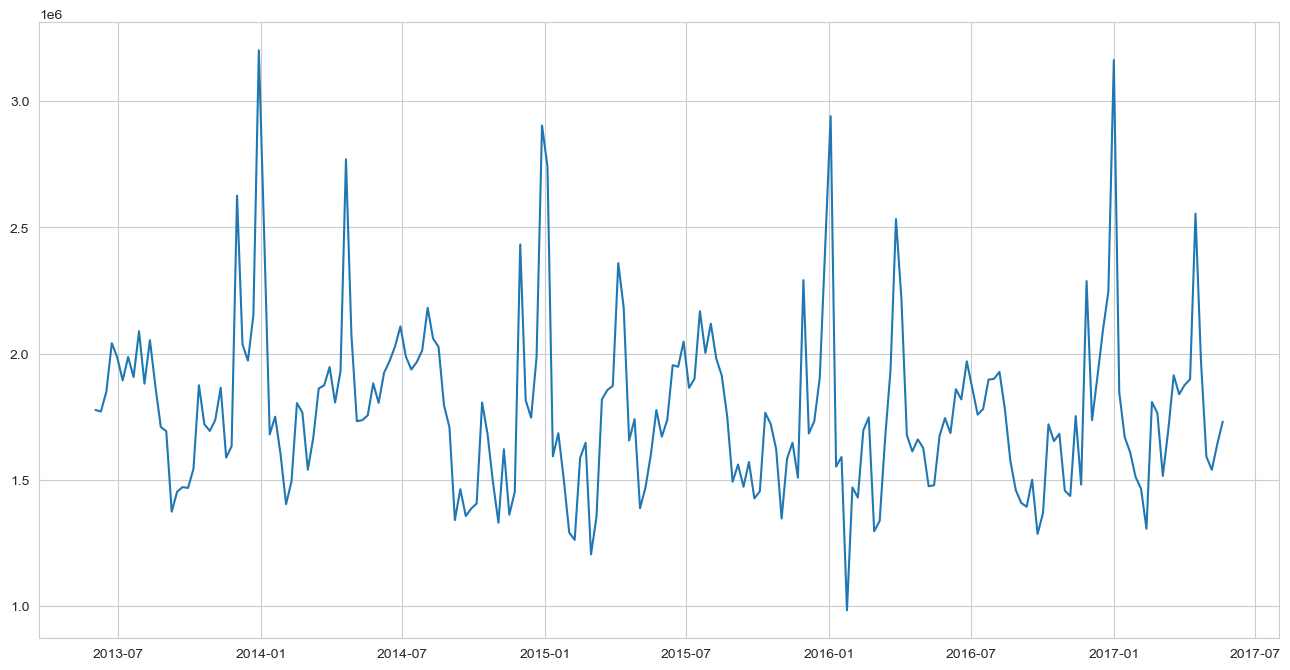

In [19]:
plt.figure(figsize=(16,8))
plt.plot(df_ttrain['ds'], df_ttrain['y'])

## Building a model

We call Prophet and fit it to our DataFrame `df_final`.

In [45]:
m = Prophet()
m.fit(df_ttrain)

15:14:48 - cmdstanpy - INFO - Chain [1] start processing
15:14:48 - cmdstanpy - INFO - Chain [1] done processing


Next, we fill out the date column with 52 weeks into the future.

In [46]:
future = m.make_future_dataframe(periods=52, freq = 'W')
future.head()

,ds
0,2013-06-02
1,2013-06-09
2,2013-06-16
3,2013-06-23
4,2013-06-30


Then we call the `predict` method on `future`, to get predictions $\hat y$.

In [5]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

NameError: name 'm' is not defined

Let's plot the predictions (blue curve) together with the actual data (black dots) to get an initial idea of how the model did.

In [48]:
#We can use the interactive features of this plot to find dates of holiday spikes in the training data
plot_plotly(m, forecast)
#I'm not sure how to plot the errors here or to include the actual values for the train_test set

One thing that is immediately noticeable about the default model's predictions are that its largest errors are from underestimating large peaks in the data that seem to repeat each year. Typically, a good model will be conservative when fitting to outlying values like these because the assumption is that outliers are noise, rather than signal. However, this is where an understanding of the data generating process (DGP) is key to building an effective model. In the case of Broadway sales, we know that sales tend to (or would be reasonably expected to) spike around certain holidays on which customers prefer to see shows. We can use `Prophet.plot`'s interactive plotting feature to identifying the dates on which the largest spikes in sales occur each year and compare them to when holidays fell in those given years.

Doing so, we find that the 3 largest sales weeks in each year of the dataset were immediately following Easter, Thanksgiving/Black Friday, and Christmas. Although, there are other, smaller peaks and valleys in the dataset that seem to re-occur around the same time each year (e.g. late January and late Summer are slow times, mid-Summer is a good for sales) they do not correspond with holidays and the effects are more temporally inconsistent, so it is less clear that the effects seen are due to factors that will predictably affect gross sales on a particular week in the future. In addition, specifying more holidays would reduce the parsimony of the model and risk overfitting if these patterns in the data are noise, so we should only to specify the 3 holidays mentioned above.

Because the dates in the dataset are those of the last day of each week, they will not always fall directly on each holiday. However, we did see that in the training data, the spike always falls on the next date following the holiday, which makes sense because the effect of the holiday on sales will not be observed until after it has occurred. However, this makes it slightly more challenging to identify the "holidays" to specify in the model because we cannot simply look up the dates on which each holiday fell in each year and input them into the model, as they might not fall on a date in the set. Instead, we identified them manually using the interactive plotting feature and input those dates into the data frame below.

We only did this for the training data. If we had looked for spikes in the testing data and specified holidays on those dates, it would have artificially inflated the model's performance by "peaking" at the test data. Instead, we blindly estimated that a holiday spike *should* occur on the first date following the holiday in the test year.

Now that we've identified the holiday spikes in the training data and where we expect them to be in the test data, we can put those dates into a dataframe of holidays. `Prophet` requires us to use specific column names for the data frame.

In [52]:
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2013-12-29', '2014-12-28','2016-01-03','2017-01-01','2017-12-31','2018-12-30'])})
 
christmas

,holiday,ds
0,christmas,2013-12-29
1,christmas,2014-12-28
2,christmas,2016-01-03
3,christmas,2017-01-01
4,christmas,2017-12-31


In [53]:
thxgiving = pd.DataFrame({
  'holiday': 'thxgiving',
  'ds': pd.to_datetime(['2013-12-01', '2014-11-30','2015-11-29','2016-11-27','2017-11-26','2018-11-25'])})
thxgiving

,holiday,ds
0,thxgiving,2013-12-01
1,thxgiving,2014-11-30
2,thxgiving,2015-11-29
3,thxgiving,2016-11-27
4,thxgiving,2017-11-26


In [54]:
easter = pd.DataFrame({
  'holiday': 'easter',
  'ds': pd.to_datetime(['2014-04-20', '2015-04-05','2016-03-27','2016-11-27','2017-04-16','2018-04-01','2019-04-21'])})
easter

,holiday,ds
0,easter,2014-04-20
1,easter,2015-04-05
2,easter,2016-03-27
3,easter,2016-11-27
4,easter,2017-04-16
5,easter,2018-04-01


In [55]:
holidays=pd.concat((christmas, thxgiving, easter))#Combine each holiday's dataframe into a single one

In [56]:
holidays

,holiday,ds
0,christmas,2013-12-29
1,christmas,2014-12-28
2,christmas,2016-01-03
3,christmas,2017-01-01
4,christmas,2017-12-31
0,thxgiving,2013-12-01
1,thxgiving,2014-11-30
2,thxgiving,2015-11-29
3,thxgiving,2016-11-27
4,thxgiving,2017-11-26


There are some tweaks to the default model that are appropriate given our data. For example, the default model looks for multiseasonality. This includes trends over the course of a day or week. However, because we have weekly data, there can be no seasonality at those levels, so we tell the model not to look for it. Further, we have no theoretical reason to believe there was something that caused a change in the trend of the data, so we could set that argument to zero. Otherwise, we can leave it up to `Prophet` to detect any changepoints automatically by not specifying an argument.

In [57]:
#Fitting the actual model
m2 = Prophet(weekly_seasonality=False,
            daily_seasonality=False,
            holidays=holidays)#feed the holidays arguments the dataframe we just created

m2.fit(df_ttrain)

15:24:14 - cmdstanpy - INFO - Chain [1] start processing
15:24:14 - cmdstanpy - INFO - Chain [1] done processing
15:24:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
15:24:14 - cmdstanpy - INFO - Chain [1] start processing
15:24:15 - cmdstanpy - INFO - Chain [1] done processing


Here we make a dataframe that is simply all of the dates in the training and test data for the model to predict.

In [59]:
future2 = m2.make_future_dataframe(periods=52, freq = 'W')
future2.head()

,ds
0,2013-06-02
1,2013-06-09
2,2013-06-16
3,2013-06-23
4,2013-06-30


In [60]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
254,2018-04-22,1.726196e+06,1.540287e+06,1.910414e+06
255,2018-04-29,1.615449e+06,1.422502e+06,1.805036e+06
256,2018-05-06,1.533179e+06,1.355569e+06,1.726640e+06
257,2018-05-13,1.517829e+06,1.330061e+06,1.709343e+06
258,2018-05-20,1.563526e+06,1.376534e+06,1.750304e+06


In [61]:
plot_plotly(m2, forecast2)#Make another interactive plot to visualize the more specified model

We can see that the model fits to the holiday spikes in the training data much more aggressively here. While we can't see how much that improves the predictions from the plot (as the `prophet.plot` does not accept the actual values for the test set, just the dates), we can see that the predicted spikes around holidays are much higher, implying that the model will also be more aggressive in predicting out-of-set values, which will likely make for a better model, given what we see historically.

## Diagnostics

Next, we want to evaluate how well the model fits the data. `Prophet` includes subpackages to make this simple. Because `Prophet` is a Bayesian model than does not use maximum likelihood estimation, unlike the SARIMA and AR models, we cannot calculate the AIC to scrutinize model performance. Hoewever, we can perform with cross validation (CV) within the training set and use it to calculate other performance metrics.

Time series CV requires us to set a prediction horizon. This is how far into the future we want the model to predict. We are building our model to predict outcomes up to 1 year in the future, so it is appropriate to set our horizon equal to 52 weeks. However, the default size of the initial training period is set to 3 times the size of the horizon (in this case, 3 years) and the default cutoff between forecasts is half the length of the horizon (in this case 26 weeks). We only have 5 years of training data(with 1 year subset out), so using the default sizes for these arguments based on a year-long horizon would exahust the data before we could make a meaningful number of forecasts. As a result, we should tweak the other arguments to fit the data limitations.

We set the initial training period to be 2 years (104 weeks) and the cutoff to be $\frac{1}{4}$ of a year. More plainly, the CV will start by training the model on the first 2 years of data and predicting the following year, then it will train on the first 1 $\frac{1}{4}$ years and predict the following year, etc. until it finally trains on the first 3 years and predicts the final year. This results in 4 forecasts.

In [70]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m2, initial='104 W', horizon='52 W', period='13 W')
#The unit of weeks needs to be specified in a way that pd.Timedelta can process
#(it will convert it to days, which will be visible in the output of the function)

  0%|          | 0/8 [00:00<?, ?it/s]

10:55:49 - cmdstanpy - INFO - Chain [1] start processing
10:55:49 - cmdstanpy - INFO - Chain [1] done processing
10:55:49 - cmdstanpy - INFO - Chain [1] start processing
10:55:49 - cmdstanpy - INFO - Chain [1] done processing
10:55:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:55:49 - cmdstanpy - INFO - Chain [1] start processing
10:55:49 - cmdstanpy - INFO - Chain [1] done processing
10:55:50 - cmdstanpy - INFO - Chain [1] start processing
10:55:50 - cmdstanpy - INFO - Chain [1] done processing
10:55:50 - cmdstanpy - INFO - Chain [1] start processing
10:55:50 - cmdstanpy - INFO - Chain [1] done processing
10:55:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:55:50 - cmdstanpy - INFO - Chain [1] start processing
10:55:53 - cmdstanpy - INFO - Chain [1] done processing
10:55:53 -

In [1]:
df_cv

NameError: name 'df_cv' is not defined

The output of the cross validation operation (above) is a dataframe including the predicted y-values ($\hat{y}$) for each date. Because the cutoff between forecasts was smaller than the horizon, some dates were forecasted twice. In this case, the default is to include the $\hat{y}$ forecasted with the larger of the two training sets, so that each date includes only a single $\hat{y}$. Further, the cross validation dataframe includes upper and lower bounds for $\hat{y}$ and the actual $y$ value observed on each date.

The latter can be used to calculate performance metrics with the `prophet` package's built-in operation. We simply need to feed it the cross validation dataframe and it will create a new dataframe with the mean squared error (MSE) and root MSE as well as the mean absolute error (MAE), and the mean absolute percent error (MAPE), in addition to other metrics.

In [73]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,21 days,3.418020e+10,184878.880182,132013.548730,0.080927,0.049236,0.078162,0.80000
1,28 days,2.259557e+10,150318.230325,128314.334470,0.075037,0.083257,0.077269,0.72500
2,35 days,1.879425e+10,137092.125563,117693.520453,0.065560,0.048222,0.068339,0.76875
3,42 days,2.510100e+10,158432.959930,118807.136777,0.058702,0.039727,0.060661,0.72500
4,49 days,3.865865e+10,196618.032626,148225.827142,0.076223,0.057850,0.075663,0.70000


Each metric can be plotted over the length of the horizon using plot_cross_validation_metric. We can see that while the metrics do fluctuate over the course of the horizon, they do not increase near the end of the horizon. This suggests that the model's predictive accuracy does not wane for dates further in the future, which is atypical for time series models.

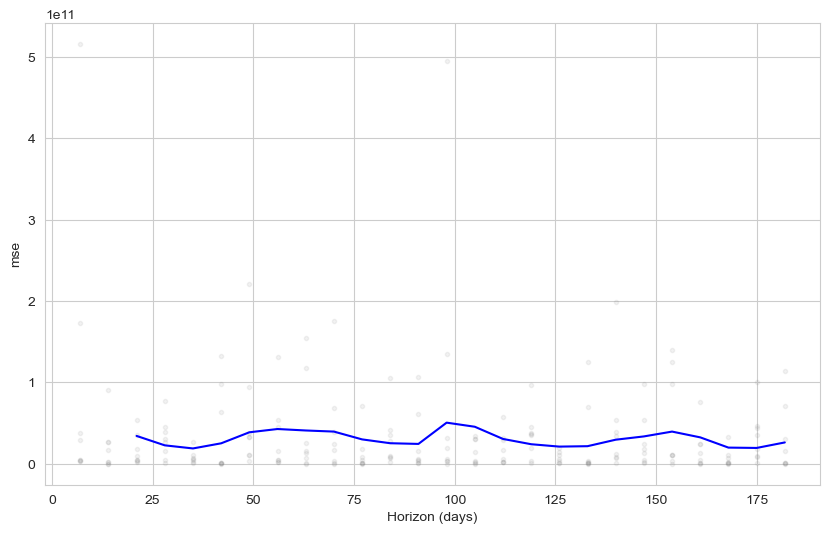

In [76]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

# Hyperparameter tuning

There are three main hyperparameters that likely require tuning: `changepoint_prior_scale`, `seasonality_prior_scale`, and `holiday_prior_scale`. They all control the flexibility of the model to fit the each of the main characteristics of the data (trend, seasonality, and holidays). We will tune the parameter by looping the `Prophet` model over the training data using different parameters each time. This method of tuning is computationally expensive, so if you have strong priors that you can use to narrow down the number of parameter values to try out, it can be useful. We have strong theoretical reasons (from our research on the DGP) to believe that seasonality and holiday effects in the training data are signal, not noise. Therefore, we might expect that high values for these parameters (giving more flexibility to the model to fit itself on these effects) will might result in a more accurate model. In a real-world application, we might only test out larger values for these parameters. However, for our educational purposes here, we will use the full range of values recommended in the `prophet` documentation to cover all our bases.

In [2]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, weekly_seasonality=False,
            daily_seasonality=False, holidays=holidays).fit(df_ttrain)  # Fit model with given parameter grid
    df_cv = cross_validation(m, initial='104 W', horizon='52 W', period='13 W', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

NameError: name 'Prophet' is not defined

In [ ]:
best_params = all_params[np.argmin(rmses)]#This will return the parameters that create the model with the lowest RMSE
print(best_params)

Surprisingly, the best parameter values were quite low in all cases, so it was a good decision to include those values in our test.

Using these findings we can build a new model object specifying these parameters.

In [3]:
m3 = Prophet(weekly_seasonality=False,
            daily_seasonality=False,
            holidays=holidays, 
            changepoint_prior_scale= 0.01,
            seasonality_prior_scale= 0.01, 
            holidays_prior_scale= 0.1
            )

NameError: name 'Prophet' is not defined

# Final test on future data
So far, we have performed all of our model specification using in-sample prediction (i.e. predicting y-values for a subset of dates in the training set). Now that we have finalized our model, we can see how well it predicts values that it has never previously predicted. We did not use the test data to specify the model to avoid overfitting the model to the test data, thereby artificially inflating its performance in predicting that specific dataset.

In [ ]:
#start by making the final train/test split
train_start_date = datetime.strptime('2013-06-02', '%Y-%m-%d')
train_end_date = datetime.strptime('2018-05-27', '%Y-%m-%d')

test_start_date = datetime.strptime('2018-06-03', '%Y-%m-%d')
test_end_date = datetime.strptime('2019-05-26', '%Y-%m-%d')

df_full = df_week_gross_series.loc[(df_week_gross_series.ds >= train_start_date) & (df_week_gross_series.ds <= test_end_date)].reset_index(drop = True)
df_train = df_full.loc[df_full.ds <= train_end_date]
df_test = df_full.loc[df_full.ds >= test_start_date]

df_test

In [ ]:
#fit the final model to the complete training data
m3.fit(df_train)

In [4]:
future_final = m3.make_future_dataframe(periods = 52, freq = 'W')
future_final.tail()

NameError: name 'm3' is not defined

In [ ]:
forecast_final = m3.predict(future_final)
forecast_final['actuals'] = df_full['y'] #Do we want to calculate the errors for the fit of the model to the entire data set, like this?
#Or just its errors for its predictions of the test set?
forecast_final['error'] = np.abs(forecast_final['actuals'] - forecast_final['yhat'])
forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

Next we compute the Root Mean Squared Error on the test data, and divide it by the average actual value in the test data to get an idea of how far off the predictions are (the test data starts in `forecast` at index 260).

In [ ]:
test_errors = forecast_final['error'][260:]
rmse = np.sqrt(1/len(test_errors)*np.sum(test_errors**2))
percent = rmse/np.mean(forecast_final['actuals'][260:])
print('The Root Mean Squared Error on the test data is ' + str(rmse) + '.')
print('So the predictions vary from the actual values by about ' + str(percent*100) + '% on average.')

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(forecast_final['ds'], forecast_final['actuals'], label = 'actuals')
plt.plot(forecast_final['ds'], forecast_final['yhat'], label = 'predictions')
plt.plot(forecast_final['ds'], forecast_final['error'], label = 'error')
plt.plot([test_start_date, test_start_date], [0, 3500000], linestyle = '--')
plt.legend()

Fine-tuning the model improved its predictive accuracy around holiday spikes in gross sales, where underestimations due to an inappropriately conservative model were the main source of error. We can see that the the model still slightly underestimates holiday sales in the test set, but the errors due to holidays are now comparable to errors in other weeks.